In [1]:
## install 필요
# !pip install -q -U tensorflow-text --quiet
# !pip install -q tf-models-official

In [2]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
import pickle
import datetime
import time
import re
import random

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

# book_review로 긍부정_dataset 만들기

In [77]:
book = pd.read_parquet('files/book_user_14_20.parquet', engine='pyarrow')

### 평점을 1~5점까지 다양하게 준 사람을 훈련 데이터로 (평점을 전부 5점으로만 준 사람의 리뷰 데이터는 신뢰도 떨어짐)

In [78]:
def overall_count(a):
    return a.overall.nunique()

In [79]:
user_overall_nunique = book.groupby('reviewerID').apply(overall_count)

In [80]:
uon_vc = pd.DataFrame(user_overall_nunique)[0].value_counts()

In [81]:
overall_5_users = list(user_overall_nunique[user_overall_nunique==5].index)

In [82]:
new_book = book[book.reviewerID.isin(overall_5_users)]

### 5점 준게 많아서 5점을 긍정으로, 1,2점을 부정으로

In [103]:
neg_reviews = list(new_book[new_book.overall.isin([1,2])].reviewText)
neg_reviews = list(set(neg_reviews))
neg_reviews = [i for i in neg_reviews if i != None]

In [104]:
pos_reviews = list(new_book[new_book.overall==5].reviewText)
pos_reviews = list(set(pos_reviews))
pos_reviews = [i for i in pos_reviews if i != None]

In [105]:
print(len(pos_reviews))
print(len(neg_reviews))

279756
86157


### train, test - random으로 split

In [124]:
test_pos_reviews = []
random_ind_list = [i for i in range(len(pos_reviews))]
pop_ind_list = random.sample(random_ind_list, len(pos_reviews)//5)
for ind in pop_ind_list:
    test_pos_reviews.append(pos_reviews[ind])
train_pos_reviews = list(set(pos_reviews) - set(test_pos_reviews))

In [125]:
test_neg_reviews = []
random_ind_list = [i for i in range(len(neg_reviews))]
pop_ind_list = random.sample(random_ind_list, len(neg_reviews)//5)
for ind in pop_ind_list:
    test_neg_reviews.append(neg_reviews[ind])
train_neg_reviews = list(set(neg_reviews) - set(test_neg_reviews))

In [126]:
# train_pos_reviews = []
# test_pos_reviews = []
# random_ind_list = [i for i in range(len(pos_reviews))]
# pop_ind_list = random.sample(random_ind_list, len(pos_reviews)//5)
# for ind in tqdm(range(len(pos_reviews))):
#     if ind in pop_ind_list:
#         test_pos_reviews.append(pos_reviews[ind])
#     else:
#         train_pos_reviews.append(pos_reviews[ind])

In [127]:
# train_neg_reviews = []
# test_neg_reviews = []
# random_ind_list = [i for i in range(len(neg_reviews))]
# pop_ind_list = random.sample(random_ind_list, len(neg_reviews)//5)
# for ind in tqdm(range(len(neg_reviews))):
#     if ind in pop_ind_list:
#         test_neg_reviews.append(neg_reviews[ind])
#     else:
#         train_neg_reviews.append(neg_reviews[ind])

In [128]:
print(len(train_pos_reviews))
print(len(test_pos_reviews))
print(len(train_neg_reviews))
print(len(test_neg_reviews))

223805
55951
68926
17231


In [129]:
for n,r in enumerate(train_pos_reviews):
    f = open(f"book_review/train/pos/{n}.txt", 'w')
    f.write(r)
    f.close()
for n,r in enumerate(test_pos_reviews):
    f = open(f"book_review/test/pos/{n}.txt", 'w')
    f.write(r)
    f.close()
for n,r in enumerate(train_neg_reviews):
    f = open(f"book_review/train/neg/{n}.txt", 'w')
    f.write(r)
    f.close()
for n,r in enumerate(test_neg_reviews):
    f = open(f"book_review/test/neg/{n}.txt", 'w')
    f.write(r)
    f.close()

# code

In [130]:
dataset_dir = 'book_review'
train_dir = os.path.join(dataset_dir,'train')

In [131]:
# hidden folder 생기는 경우 있어서 제거해줌 - hidden folder 있으면 class에 포함됨
if '.ipynb_checkpoints' in os.listdir("book_review/train"):
    shutil.rmtree("book_review/train/.ipynb_checkpoints")
if '.ipynb_checkpoints' in os.listdir("book_review/test"):
    shutil.rmtree("book_review/test/.ipynb_checkpoints")

In [132]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'book_review/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'book_review/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'book_review/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 292732 files belonging to 2 classes.
Using 234186 files for training.
Found 292732 files belonging to 2 classes.
Using 58546 files for validation.
Found 73182 files belonging to 2 classes.


In [133]:
class_names

['neg', 'pos']

In [134]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(2):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b"(Clean contemporary romance) ---) Even go as far as saying Christian love story because heroine mentions her faith and quotes bible at one point.\n\nI loved this book!!!! I gave it 5 star review. Hero is rodeo star that stops by his brother's ranch and literally saves heroine the first time she meets her. They form this instant attraction but both come with childhood trauma that affects them. Heroine especially had some strong trust issues and abandonment issues.\n\nHowever, hero realizes he has feelings for the heroine he never felt before and is quicker to act on the connection than the heroine. He is real patient, caring and protective. Slowly he chips away at her defenses and heroine starts to allow him in. Nice ending but no epilogue.\n\nSafe read. Great chemistry between hero and heroine. Clean read, most kisses and caressing. No OW or OM. Conflicts were resolved very easily. The story focuses on how hero won her over. Very sweet read. Highly recommended this read."
Lab

In [149]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]
# bert_model_name = 'electra_base'
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [150]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [151]:
# text_test = ['this is such an amazing movie!. I hate the movie', 'hello world']
# text_preprocessed = bert_preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

In [152]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [153]:
# bert_results = bert_model(text_preprocessed)

# print(f'Loaded BERT: {tfhub_handle_encoder}')
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [154]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [168]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

In [169]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [170]:
epochs = 6
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [171]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [172]:
len(train_ds)

7319

In [173]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/6
7319/7319 [==============================] - 1431s 195ms/step - loss: 0.3298 - binary_accuracy: 0.8411 - val_loss: 0.2051 - val_binary_accuracy: 0.9202
Epoch 2/6
7319/7319 [==============================] - 1423s 194ms/step - loss: 0.1986 - binary_accuracy: 0.9193 - val_loss: 0.1814 - val_binary_accuracy: 0.9263
Epoch 3/6
7319/7319 [==============================] - 1418s 194ms/step - loss: 0.1752 - binary_accuracy: 0.9311 - val_loss: 0.1736 - val_binary_accuracy: 0.9327
Epoch 4/6
7319/7319 [==============================] - 1417s 194ms/step - loss: 0.1612 - binary_accuracy: 0.9380 - val_loss: 0.1743 - val_binary_accuracy: 0.9329
Epoch 5/6
7319/7319 [==============================] - 1410s 193ms/step - loss: 0.1527 - binary_accuracy: 0.9414 - val_loss: 0.1742 - val_binary_accuracy: 0.9347
Epoch 6/6
7319/7319 [==============================] - 1414s 193ms/step - loss: 0.1468 - binary_ac

# test 정확도

In [174]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

2287/2287 [==============================] - 137s 60ms/step - loss: 0.1783 - binary_accuracy: 0.9367
Loss: 0.17828597128391266
Accuracy: 0.9366511106491089


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


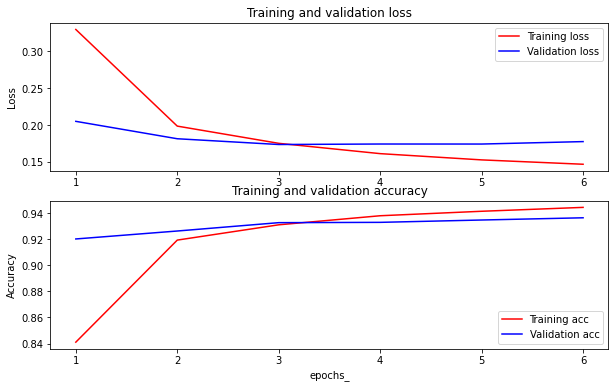

In [175]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_ = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs_, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('epochs_')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_, acc, 'r', label='Training acc')
plt.plot(epochs_, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs_')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [176]:
dataset_name = 'book'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [177]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [178]:
def print_my_examples(inputs, results):
    result_for_printing = \
      [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                           for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    "Most certainly one of the most heart warming books I've had the pleasure of reading in a long time ! Thoroughly enjoyed it ! And would ask anyone getting the chance to read ,please do"
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.998333
input: The movie was great!           : score: 0.996495
input: The movie was meh.             : score: 0.414697
input: The movie was okish.           : score: 0.038098
input: The movie was terrible...      : score: 0.017076
input: Most certainly one of the most heart warming books I've had the pleasure of reading in a long time ! Thoroughly enjoyed it ! And would ask anyone getting the chance to read ,please do : score: 0.998497

Results from the model in memory:
input: this is such an amazing movie! : score: 0.998333
input: The movie was great!           : score: 0.996495
input: The movie was meh.             : score: 0.414697
input: The movie was okish.           : score: 0.038098
input: The movie was terrible...      : score: 0.017076
input: Most certainly one of the most heart warming books I've had the pleasure of reading in a long time ! Thoroughly enjoyed it ! And would ask anyone getting the c

In [179]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.998333
input: The movie was great!           : score: 0.996495
input: The movie was meh.             : score: 0.414697
input: The movie was okish.           : score: 0.038098
input: The movie was terrible...      : score: 0.017076
input: Most certainly one of the most heart warming books I've had the pleasure of reading in a long time ! Thoroughly enjoyed it ! And would ask anyone getting the chance to read ,please do : score: 0.998497



# 리뷰 긍부정 점수 컬럼 생성

In [4]:
df = pd.read_parquet('merge_book_2015_30_5.parquet', engine='pyarrow')

In [5]:
reloaded_model = tf.saved_model.load('./book_bert')

In [6]:
df_reviews = []
for i in df.reviewText:
    if i != None:
        df_reviews.append(i)

In [7]:
len(df_reviews)

823236

In [8]:
# review_sentiment_scores = tf.sigmoid(reloaded_model(tf.constant(df_reviews)))

In [9]:
# 한번에 하면 메모리 에러 나서 100개씩 진행
review_score_list = []
for i in tqdm(range(len(df_reviews)//100+1)):
    for j in reloaded_model(tf.constant(df_reviews[i*100:i*100+100])):
        review_score_list.append(float(j))

100%|██████████| 8233/8233 [23:42<00:00,  5.79it/s]


In [10]:
len(review_score_list)

823236

In [11]:
review_score_list = tf.sigmoid(review_score_list)

In [19]:
review_score_list_float = []
for i in tqdm(review_score_list):
    review_score_list_float.append(float(i))

100%|██████████| 823236/823236 [02:05<00:00, 6555.92it/s]


In [21]:
total_review_score_list = review_score_list_float.copy()

In [22]:
# review가 none 값 들어있는 index에 감성점수도 none값 넣어줌
none_review_index = list(df[pd.isnull(df.reviewText)].index)

In [23]:
for i in none_review_index:
    total_review_score_list.insert(i,None)

In [24]:
df['review_sentiment_score'] = total_review_score_list

In [27]:
df.to_parquet('merge_book_sentiment_2015_30_5.parquet', engine='pyarrow', index=False)